# Module 3: Water flow in roots

by Daniel Leitner, Andrea Schnepf 

## Theory


Roughly based on Roose and Fowler (2004) and Doussan et al. (2006).


The axial water flux in a xylem is given by 
\begin{eqnarray} 
q_z = - k_z \left( \frac{\partial \psi_r}{\partial z} - e_z \cdot v \right), \label{axialflux}
\end{eqnarray}
with units [cm$^3$ day$^{-1}$], see Eqn 3.1 Roose and Fowler, 2004. 
The parameter $k_z$ is the axial conductance [cm$^3$ day$^{-1}$], 
$\psi_r$ is the pressure inside the xylem [cm], 
$e_z$ the downward unit vector [1],
and $v$ the normed direction of the xylem [1]. Thus Eqn \ref{axialflux} can be expressed as
\begin{eqnarray}
q_z = - k_z \left( \frac{\partial \psi_r}{\partial z} + v_3 \right), \label{axialflux2}
\end{eqnarray}
where $v_3$ is the $z$-component of the normed xylem direction. \\

\noindent
The radial flux is given by 
\begin{eqnarray}
q_r = - 2 a \pi l k_r (\psi_s - \psi_r),
\end{eqnarray}
with units [cm$^3$ day$^{-1}$] (based on Eqn 3.3 Roose and Fowler, 2004), 
where $a$ is the root radius [cm], 
$l$ is the segments length [cm], 
$k_r$ is the radial conductance [day$^{-1}$], 
and $\psi_s$ is the soil matric potential of the surrounding soil [cm]. \\

\noindent
The net flux is given by
\begin{eqnarray}
q = q_z + q_r,
\end{eqnarray} 
and mass conservation yields
\begin{eqnarray}
2 a \pi k_r (\psi_s - \psi_r) = - k_z \frac{\partial^2 \psi_r}{\partial z^2} \label{masscons}
\end{eqnarray}
(see Eqn 3.4 Roose and Fowler, 2004).

\noindent
For discretisation we use first Kirchhoff's law: In a graph that represents the root system for each node $i$ the sum of fluxes must be zero 
\begin{eqnarray}
\sum_{j \in N(i)} q_{ij} = 0,  \label{KH}
\end{eqnarray}
where $N(i)$ are the nodes that are connected to node $i$ and $q_{ij}$ is the net flux of the edge connecting node $i$ and node $j$.


## Benchmarks


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from math import *
from rsml import * # located in the same directory 

### Benchmark M3.1: Single Root

For the first benchmark problem we assume a vertical single root segment surrounded by a static soil with constant soil matric potential. At the root collar we prescribe constant pressure, at the root tip a no-flux boundary condition is applied.   

We pick the following parameters defining Benchmark 1: 

In [2]:
L = 50            # length of single straight root [cm]
a = 0.2           # radius  [cm]
kx = 4.32e-2      # axial conductivity [cm^3 / day] 
kr = 1.728e-4     # radial conductivity [1 / day]
p_s = -200        # static soil matric potiential [cm]
p0 = -1000        # dirichlet bc at top [cm]

### Analytical solution

For constant $k_r$ and $k_z$ we can solve Eqn \ref{masscons} yielding 
\begin{eqnarray}
\psi_r(z) := \psi_s + d_1 e^{\sqrt{c} z } + d_2 e^{-\sqrt{c} z} \label{analytic_flux}
\end{eqnarray} 
with $c = 2 a \pi k_r / k_z$. 

In the following the constants $d_1$, and $d_2$ [cm] are calculated from the boundary conditions.
The Dirichlet boundary conditions at the top $\psi_r(0) =\psi_0$ is inserted into the analytic solution Eqn \ref{analytic_flux}, and yields
\begin{eqnarray}
\psi_s + d_1  + d_2  = \psi_0.
\end{eqnarray}

The Neumann boundary conition $q_z(L) = 0$ (Eqn \ref{axialflux2}) leads to 
\begin{eqnarray}
\frac{\partial \psi_r}{\partial z} (L) = v_3.
\end{eqnarray}
Using the derivation of the analytical solution yields
\begin{eqnarray}
d_1 \sqrt{c} e^{\sqrt{c} L } - d_2 \sqrt{c} e^{-\sqrt{c} L}  = v_3.
\end{eqnarray}


For a straight segment $v_3 = -1$. Therefore, we solve 
\begin{align}
\left(\begin{array}{cc}
  1 & 1  \\
 \sqrt{c} \exp{(\sqrt{c} L)} & -\sqrt{c} \exp{(-\sqrt{c} L)} \\
\end{array}\right)
\left(\begin{array}{c}
  d_{1}  \\
  d_{2}  \\
\end{array}\right)
{} &= 
\left(\begin{array}{c}  
  \psi_0-\psi_s \\
  -1 \\
\end{array}\right)
\end{align}

We solve for the constants $d_1$, and $d_2$, and plot the results

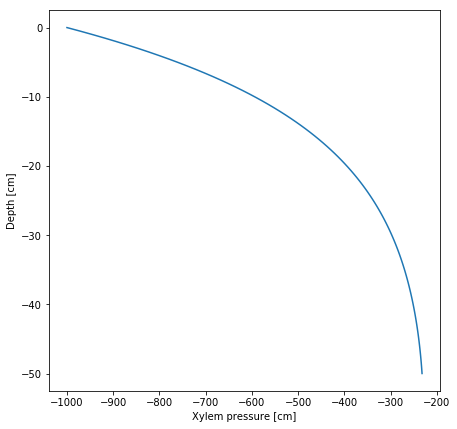

In [3]:
# Analytical solution
c = 2*a*pi*kr/kx
p_r = lambda z: p_s + d[0]*exp(sqrt(c)*z) + d[1]*exp(-sqrt(c)*z)

# Boundary conditions
AA = np.array([[1,1], [sqrt(c)*exp(sqrt(c)*(-L)), -sqrt(c)*exp(-sqrt(c)*(-L))] ]) 
bb = np.array([p0-p_s, -1]) 
d = np.linalg.solve(AA, bb) 

# Plot results
fig=plt.figure(figsize=(7, 7))
za_ = np.linspace(0,-L,100)
pr = list(map(p_r, za_))
plt.plot(pr,za_)
plt.xlabel("Xylem pressure [cm]")
plt.ylabel("Depth [cm]")
plt.show()

### Benchmark M3.2: Root System

In the following benchmark, we extend benchmark M3.1 from a single root to a root system. We consider water flow inside a small static root system of a lupine plant which was grown for 14 days in a soil-filled column of 20 cm depth and 7 cm diameter. The root system was imaged by MRI at Forschungszentrum Jülich; the resulting root grid is provided in RSML, DGF and RootSys formats in the folder "root_grid/RootSystem.rsml".  

In [4]:
polylines, props, funcs = read_rsml("root_grid/RootSystem.rsml")
print("Properties:") # one per root
for key, v in props.items() :
    print("\t", key)
print("Functions:") # oner per root node
for key, v in funcs.items() :
    print("\t", key)

Properties:
	 parent-poly
	 length
	 type
	 parent-branch
	 parent-node
Functions:
	 emergence_time
	 diameter


We can visualize this small root system by the following script, where colors denote the root type:

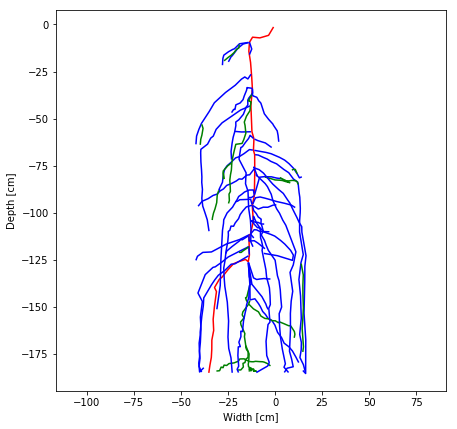

In [5]:
fig=plt.figure(figsize=(7, 7))
cols = ['r','b','g'] 
for i,pl in enumerate(polylines):
    nodes = np.array(pl)
    ci = int(props["type"][i]-1)
    plt.plot(nodes[:,1],nodes[:,2], cols[ci]) 
plt.axis('equal')
plt.xlabel("Width [cm]")
plt.ylabel("Depth [cm]")
plt.show()

For benchmark M3.2(a) we first neglect root age and define static conductivities according to Javaux et al. (2008), and define boundary conditions as in Benchmark M3.1: At the root collar we assume -500 cm pressure head located at node index 0, and a no-flux boundary condition at the root tips. The soil is assumed to be static with a matric potential of -200 cm pressure head. 

Aim is to calculate the pressure at the nodes. 

In [6]:
kx = 4.32e-2      # axial conductivity [cm^3 / day]
kr = 1.728e-4     # radial conductivity [1 / day] 
p_s = -200        # static soil matric potiential [cm]
p0 = -500         # dirichlet bc at top [cm]

Since there is no analytical solution available to this problem, we can validate numerical codes by inter-comparison. 

In Benchmark M3.2(b) we are interested in the influence of age dependent radial and axial conductivities. We define these conductivities as: 

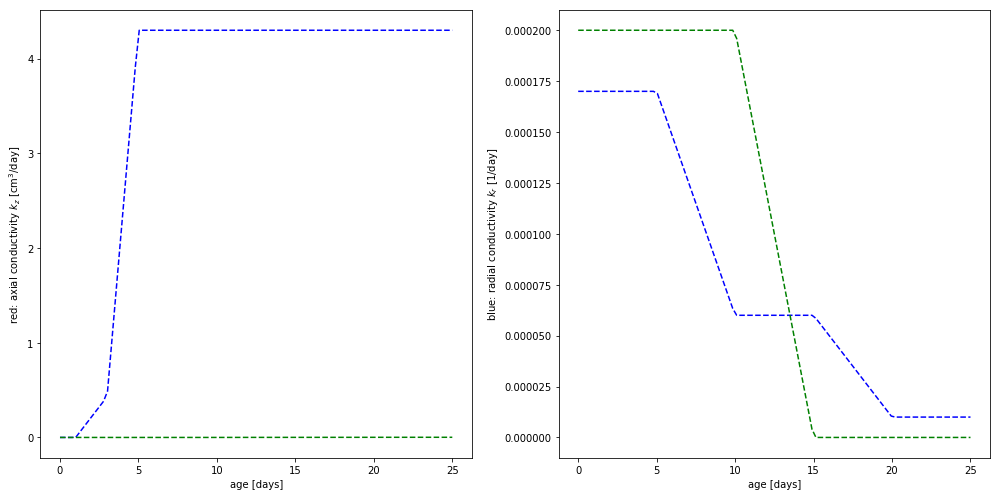

In [7]:
from scipy import interpolate
kx0 = np.array([[0,0], [1,0], [3,0.43], [5, 4.3]])
kr0 = np.array([[0,1.7e-4], [5,1.7e-4], [10,6e-5], [15,6e-5], [20,1e-5]])
kx1 = np.array([[0,0], [5,0], [10,1e-4], [12,6e-4], [23,1.7e-3]])
kr1 = np.array([[0,2e-4], [10,2e-4], [15,0]])
kx0_ = interpolate.interp1d(kx0[:,0], kx0[:,1], fill_value = 4.3, bounds_error = False)
kr0_ = interpolate.interp1d(kr0[:,0], kr0[:,1], fill_value = 1e-5, bounds_error = False)
kx1_ = interpolate.interp1d(kx1[:,0], kx1[:,1], fill_value = 1.7e-3, bounds_error = False)
kr1_ = interpolate.interp1d(kr1[:,0], kr1[:,1], fill_value = 0, bounds_error = False)

# Plot function # todo twin axes for kx would be nice
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))
age_ = np.linspace(0,25,100)
ax1.plot(age_,kx0_(age_), "b--")
ax1.plot(age_,kx1_(age_), "g--")
ax1.set_xlabel("age [days]")
ax1.set_ylabel("red: axial conductivity $k_z$ [cm$^3$/day]")
ax2.plot(age_,kr0_(age_), "b--")
ax2.plot(age_,kr1_(age_), "g--")
ax2.set_ylabel("blue: radial conductivity $k_r$ [1/day]")
ax2.set_xlabel("age [days]")

fig.tight_layout()
plt.show()

## Comparison to numerical solutions

We validate various numerical codes by solving the benchmarking problems. In the following we link to notebooks already containing Benchmark M3.1, M3.2, and M3.3

* [Homegrown Python Code from Schnepf et al. 2018](Xylem flux - Python code.ipynb)
* [Dumux](Xylem flux - Dumux.ipynb)

### Benchmark M3.1 

For an automatic comparison of the numerical results, save the results in a text file with two lines, containing comma separated depth values [cm] in the first line, and pressure head [cm] in the second, located in the folder `/xylem_flux/b1/simulatorname`.

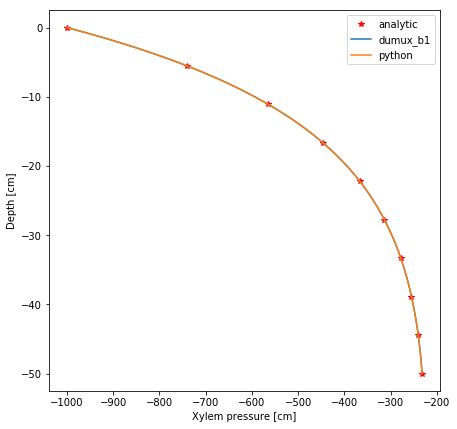

Name		 N	 Rsme		 R²		 R
dumux_b1		 100 	 0.00018796 	 0.99996830 	 0.99999997
python		 100 	 0.00000035 	 0.99998960 	 1.00000000


In [8]:
fig=plt.figure(figsize=(7, 7))   # analytical solution
y = np.linspace(0,-50,10)
plt.plot(list(map(p_r, y)),y,"r*")

j = 0 # number of files
r, rsme, rsquare, nn = [], [], [], []
l = ["analytic"]
for dirname, dirnames, filenames in os.walk('xylem_flux/b1/.'):
    filenames.sort()
    for i,f in enumerate(filenames):
        try:
            l.append(f)
            data = np.loadtxt("xylem_flux/b1/"+f,delimiter=',')
            plt.plot(data[1,:],data[0,:]) # numeric solution         
            j += 1     
            # Evaluate
            n = len(data[1,:])
            nn.append(n)
            pr_ = list(map(p_r, data[0,:])) # exact solution at data depth points  
            # calculate R
            om = np.mean(data[1,:])
            pm = np.mean(pr_)
            r_ =  np.sum((data[1,:]-om)*(pr_-pm)) / (np.sqrt(np.sum(np.square(data[1,:]-om)))*np.sqrt(np.sum(np.square(pr_-pm))) )
            r.append(r_*r_)
            # calculate R^2
            meany = np.mean(data[1,:])
            r2 = np.sum(np.square(pr_-meany)) / np.sum(np.square(data[1,:]-meany))                         
            rsquare.append(r2)            
            # calculate RSME
            rsme_ = np.square(np.sum(np.square(data[1,:]-pr_)/n))
            rsme.append(rsme_)                
        except Exception as ex:
            print("Something went wrong with file "+f)    
            print(ex)            
plt.xlabel("Xylem pressure [cm]")
plt.ylabel("Depth [cm]")
plt.legend(l)
plt.show()

print("Name\t\t", "N\t", "Rsme\t\t", "R²\t\t", "R")
for i in range(0,j):
    print(l[i+1]+"\t\t",nn[i],"\t",'{:2.8f}'.format(rsme[i]),"\t", '{:2.8f}'.format(rsquare[i]),"\t",'{:2.8f}'.format(r[i]) ) 

### Benchmark M3.2(a)

For an inter-comparison of the numerical results save the results in a text file with two lines, containing comma separated depth values [cm] in the first line, and pressure head [cm] in the second line. Locate the file in the folder `/xylem_flux/b2/simulatorname`.

1. dumux_b2 (r*):
from  -500.0 to -240.7594292  cm pressure head

2. python (g*):
from  -500.0 to -240.8228823  cm pressure head



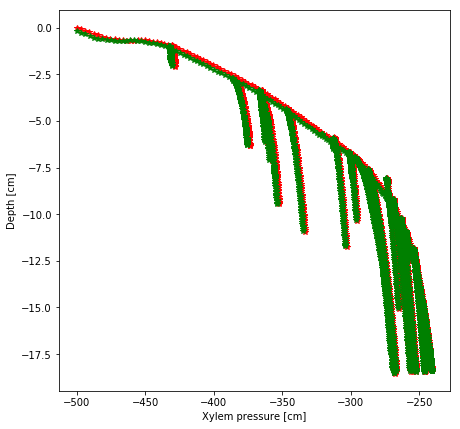

In [9]:
fig=plt.figure(figsize=(7, 7))
col = ["r*", "g*", "b*","rv", "gv", "bv"]
for dirname, dirnames, filenames in os.walk('xylem_flux/b2/.'):
    filenames.sort()
    for i,f in enumerate(filenames):
        try:
            data = np.loadtxt("xylem_flux/b2/"+f,delimiter=',')        
            print(str(i+1)+". "+f+" ("+col[i]+"):")
            print("from ", min(data[1,:]), "to", max(data[1,:]), " cm pressure head\n")        
            plt.plot(data[1,:],data[0,:],col[i])
        except Exception as ex:
            print("Something went wrong with file "+f)    
            print(ex)             
            
plt.xlabel("Xylem pressure [cm]")
plt.ylabel("Depth [cm]")        
plt.show()    

### Benchmark M3.2(b)

For an inter-comparison of the numerical results save the results in a text file with two lines, containing comma separated depth values [cm] in the first line, and pressure head [cm] in the second line. Locate the file in the folder `/xylem_flux/b3/simulatorname`.

1. python (r*):
from  -500.0 to -177.2128231  cm pressure head

2. dumux_b3 (gv):
from  -500.0 to -200.0  cm pressure head



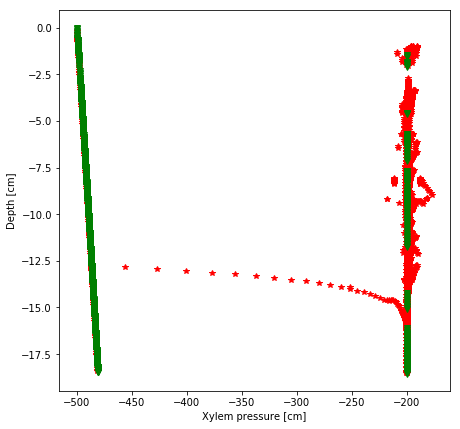

In [10]:
fig=plt.figure(figsize=(7, 7))
col = ["r*", "gv", "b*","rv", "gv", "bv"]
for dirname, dirnames, filenames in os.walk('xylem_flux/b3/.'):
    filenames.sort()
    for i,f in enumerate(filenames[::-1]):
        try:
            data = np.loadtxt("xylem_flux/b3/"+f,delimiter=',')        
            print(str(i+1)+". "+f+" ("+col[i]+"):")
            print("from ", min(data[1,:]), "to", max(data[1,:]), " cm pressure head\n")        
            plt.plot(data[1,:],data[0,:],col[i])
        except Exception as ex:
            print("Something went wrong with file "+f)    
            print(ex)
    
plt.xlabel("Xylem pressure [cm]")
plt.ylabel("Depth [cm]")        
plt.show()

## References

Doussan, C., Pierret, A., Garrigues, E., and Pages, L. (2006). Water uptake by plant roots: II - Modelling of water transfer in the soil root-system with explicit account of flow within the root system - comparison with experiments. *Plant and Soil*, 283(1-2):99–117.

Roose, T. and Fowler, A. C. (2004). A model for water uptake by plant roots. *Journal of Theoretical Biology*, 228(2):155–171.

Schnepf, A., Leitner, D., Landl, M., Lobet, G., Mai, T.H., Morandage S., Sheng, C., Zoerner, M., Vanderborght, J., Vereecken, H. (2018) CRootBox: a structural-functional modelling framework for root systems. *Annals of Botany*, 121 (5), 1033-1053
